# Models

In [4]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from yellowbrick.classifier import ConfusionMatrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb 

import warnings
warnings.filterwarnings('ignore')

## Model ( Feature Selected)

In [5]:
# Import data training and testing
X_train = np.loadtxt('../data/processed/X_train_feature.csv', delimiter=',') 
X_test = np.loadtxt('../data/processed/X_test_feature.csv', delimiter=',')

y_train = np.loadtxt('../data/processed/y_train.csv', delimiter=',')
y_test = np.loadtxt('../data/processed/y_test.csv', delimiter=',')

### Selecting model
Objeticve to this topic are create 5 default models of classifications and using the cross validation to verify the model that have a best AUC and standard deviations for this data. 

In [6]:
models = [RandomForestClassifier, 
          MultinomialNB, 
          LogisticRegression,
          KNeighborsClassifier,
          xgb.XGBClassifier,
          SVC]

In [7]:
for model in models:
    cls = model()
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    s = cross_val_score(cls, X_train, y_train, scoring='roc_auc', cv=kfold)
    print(f"{model.__name__:22} AUC: "
          f"{s.mean():.3f} STD: {s.std():.2f}")

RandomForestClassifier AUC: 0.984 STD: 0.02
MultinomialNB          AUC: 0.852 STD: 0.07
LogisticRegression     AUC: 0.986 STD: 0.02
KNeighborsClassifier   AUC: 0.976 STD: 0.02
XGBClassifier          AUC: 0.982 STD: 0.02
SVC                    AUC: 0.986 STD: 0.02


In this case, I'll select the RandonForest to construct and optmize the final model. 

### Training the model 

In [8]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [9]:
# Print summary precision and recall
summary_model_rf = classification_report(y_test, model_rf.predict(X_test), target_names=['B','M'])
print(summary_model_rf)
print(f'Accuracy: {accuracy_score(y_test, model_rf.predict(X_test))}')

              precision    recall  f1-score   support

           B       0.98      0.87      0.92        75
           M       0.79      0.97      0.87        39

    accuracy                           0.90       114
   macro avg       0.89      0.92      0.90       114
weighted avg       0.92      0.90      0.91       114

Accuracy: 0.9035087719298246


In [10]:
print(f'AUC: {roc_auc_score(y_test, model_rf.predict(X_test))}')

AUC: 0.9205128205128206


### Optimize the params
* I'll use GridSearch to construct severals models and select the best params. 

In [11]:
params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

model_rf2 = RandomForestClassifier()

In [12]:
cv = GridSearchCV(model_rf2, params, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)
print(cv.best_params_)

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}


In [13]:
model_rf3 = RandomForestClassifier(**cv.best_params_)
model_rf3.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2')

### Evaluation

In [14]:
print(classification_report(y_test, model_rf3.predict(X_test), target_names=['B','M']))
print(f'AUC: {roc_auc_score(y_test, model_rf3.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, model_rf3.predict(X_test))}')

              precision    recall  f1-score   support

           B       0.99      0.88      0.93        75
           M       0.81      0.97      0.88        39

    accuracy                           0.91       114
   macro avg       0.90      0.93      0.91       114
weighted avg       0.92      0.91      0.91       114

AUC: 0.9271794871794872
Accuracy: 0.9122807017543859


* We can note that don't have significant difference AUC about default and optmize model. 

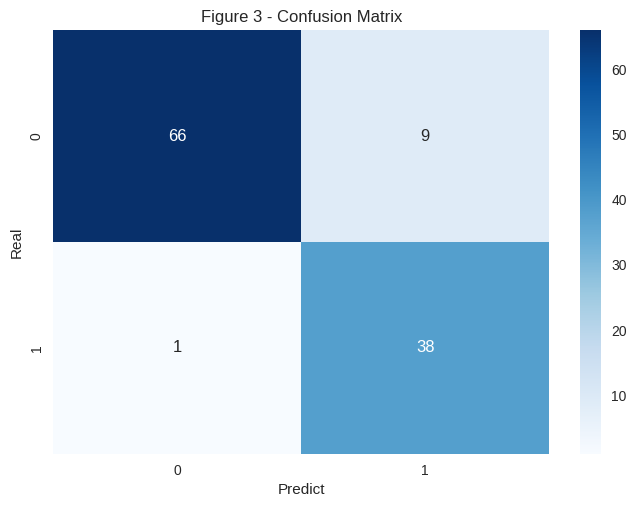

In [15]:
# plot confusion matrix
y_prev = model_rf3.predict(X_test)
conf_mat = confusion_matrix(y_test, y_prev)

# plot
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title('Figure 3 - Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

### Saving the model


In [16]:
joblib.dump(model_rf3, '../models/model_rf3_feature.pkl')

['../models/model_rf3_feature.pkl']

## Model with all feature

In [17]:
# Import data
X_train = np.loadtxt('../data/processed/X_train_all.csv', delimiter=',') 
X_test = np.loadtxt('../data/processed/X_test_all.csv', delimiter=',')

In [18]:
params = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
}

model_rf4 = RandomForestClassifier()

In [19]:
cv = GridSearchCV(model_rf4, params, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)
print(cv.best_params_)

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 300}


In [20]:
model_rf5 = RandomForestClassifier(**cv.best_params_)
model_rf5.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=300)

### Evaluation 

In [21]:
print(classification_report(y_test, model_rf5.predict(X_test), target_names=['B','M']))
print(f'AUC: {roc_auc_score(y_test, model_rf5.predict(X_test))}')
print(f'Accuracy: {accuracy_score(y_test, model_rf5.predict(X_test))}')

              precision    recall  f1-score   support

           B       0.97      0.95      0.96        75
           M       0.90      0.95      0.92        39

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114

AUC: 0.9476923076923077
Accuracy: 0.9473684210526315


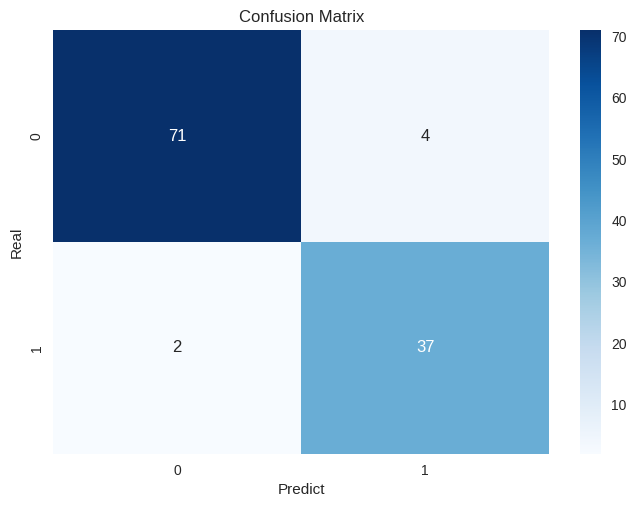

In [22]:
# plot confusion matrix
y_prev = model_rf5.predict(X_test)
conf_mat = confusion_matrix(y_test, y_prev)

# plot
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predict')
plt.ylabel('Real')
plt.show()

### Saving the model


In [23]:
joblib.dump(model_rf3, '../models/model_rf5_final.pkl')

['../models/model_rf5_final.pkl']

# Conclusion

Nesse caso o modelo que contém todas as caracteristicas/atributos desempenhou melhor em compração ao modelo que foi realizado uma seleção de atributos através da aplicação da técnica RandomForest para seleção dos principais atributos. 

Esse fator pode ser explicado pois, com a redução de caracteristicas o modelo perde complexidade, ou seja, é exposto a menores informações para o aprendizado de padrões. O método ensemble baggin no caso o RandomForest é um algorimto que pode ajustar facilmente aos dados. 

Portanto, para este caso, onde o conjunto de dados para treinamento e teste são pequenos, o uso de seleção de variáveis não apresenta ser viável, pois não há uma complexidade que possa provocar um ganho de tempo considerável. E como todas as caracteristicas trouxeram um desempenho melhor sem alterar praticamente nada em tempo de execução, a escolha do modelo com todas as carateristicas é o mais adequado. 

Esse trabalho teve como objetivo principal a estruturação de um padrão para um projeto de classificação. Dividindo em etapas como o processo de análise exploratória, preparação dos dados, modelagens e avalições dos modelos. Por fim o melhor modelo ficará disponível para o deploy. Para deploy do modelo será realizado um projeto em fastapi para sua implemetnação e disponibilização via web. 